In [8]:
import os
os.chdir(r"C:\Users\Lavanya R\CircuitGuard_Project")
print("CWD:", os.getcwd())


CWD: C:\Users\Lavanya R\CircuitGuard_Project


In [9]:
from pathlib import Path
p = Path("module06_backend.py")
print("module06_backend.py exists:", p.exists(), "size:", p.stat().st_size if p.exists() else "N/A")

import sys
proj = r"C:\Users\Lavanya R\CircuitGuard_Project"
if proj not in sys.path:
    sys.path.insert(0, proj)

from module06_backend import run_pipeline_on_pair, run_pipeline_on_folder, load_checkpoint
print("IMPORT SUCCESS — module06_backend loaded")


module06_backend.py exists: True size: 7024
IMPORT SUCCESS — module06_backend loaded


In [10]:
from pathlib import Path
CKPT = Path("checkpoints/best_effnet_b0_cpu_ultrafast.pth")   # or full path if different
TEMPLATE = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\images\Missing_hole\01_missing_hole_01.jpg")
TEST = Path(r"C:\Users\Lavanya R\Downloads\PCB_DATASET\PCB_DATASET\rotation\Missing_hole_rotation\01_missing_hole_01.jpg")
OUT = Path("inference_results_module06_test"); OUT.mkdir(exist_ok=True)

res = run_pipeline_on_pair(TEMPLATE, TEST, CKPT, OUT, resize_to=(800,800), max_rois=10)
print("Annotated saved to:", res["annotated_path"])
print("CSV saved to:", res["csv_path"])
print("Elapsed (s):", res["elapsed_sec"])


Annotated saved to: inference_results_module06_test\annotated_01_missing_hole_01.png
CSV saved to: inference_results_module06_test\detections_01_missing_hole_01.csv
Elapsed (s): 1.0695581436157227


In [11]:
from pathlib import Path
out = Path("inference_results_module06_batch")
if not out.exists():
    print("No batch output folder yet:", out)
else:
    imgs = list(out.glob("annotated_*.png"))
    cs = list(out.glob("detections_*.csv"))
    print("Annotated images:", len(imgs))
    print("CSV files:", len(cs))
    for f in sorted(out.glob("*"))[-10:]:
        print(" ", f.name)


Annotated images: 319
CSV files: 319
  detections_12_mouse_bite_01.csv
  detections_12_mouse_bite_02.csv
  detections_12_mouse_bite_03.csv
  detections_12_mouse_bite_04.csv
  detections_12_mouse_bite_05.csv
  detections_12_mouse_bite_06.csv
  detections_12_mouse_bite_07.csv
  detections_12_mouse_bite_08.csv
  detections_12_mouse_bite_09.csv
  detections_12_mouse_bite_10.csv


In [14]:
# Cell: create combined summary CSV from all detections_*.csv
from pathlib import Path
import pandas as pd

batch_dir = Path("inference_results_module06_batch")
out_summary = batch_dir / "batch_detections_summary.csv"

csv_files = sorted(batch_dir.glob("detections_*.csv"))
print("Found", len(csv_files), "detection CSVs")

if not csv_files:
    print("No per-image CSVs found in", batch_dir)
else:
    dfs = []
    for f in csv_files:
        try:
            df = pd.read_csv(f)
            df["source_csv"] = f.name
            dfs.append(df)
        except Exception as e:
            print("Failed to read", f, ":", e)
    if dfs:
        big = pd.concat(dfs, ignore_index=True)
        big.to_csv(out_summary, index=False)
        print("Wrote summary to:", out_summary, " — rows:", len(big))
    else:
        print("No valid CSVs to combine.")


Found 319 detection CSVs
Wrote summary to: inference_results_module06_batch\batch_detections_summary.csv  — rows: 3190


In [15]:
# Cell: show top-level stats & label counts
import pandas as pd
from pathlib import Path

summary_path = Path("inference_results_module06_batch/batch_detections_summary.csv")
if not summary_path.exists():
    print("Summary CSV not found — run the previous cell first.")
else:
    df = pd.read_csv(summary_path)
    print("Total detection rows:", len(df))
    if "label" in df.columns:
        print("\nPredicted label counts:")
        print(df["label"].value_counts())
    display(df.head(10))


Total detection rows: 3190

Predicted label counts:
label
Spur               1006
Short               660
Missing_hole        580
Open_circuit        444
Mouse_bite          301
Spurious_copper     199
Name: count, dtype: int64


,image,roi_idx,x0,y0,x1,y1,label,score,source_csv
0,01_missing_hole_01.jpg,0,0,1539,2914,1784,Open_circuit,0.335092,detections_01_missing_hole_01.csv
1,01_missing_hole_01.jpg,1,235,11,3129,242,Spurious_copper,0.718036,detections_01_missing_hole_01.csv
2,01_missing_hole_01.jpg,2,0,11,298,1437,Short,0.740008,detections_01_missing_hole_01.csv
3,01_missing_hole_01.jpg,3,2839,497,3125,1787,Open_circuit,0.529174,detections_01_missing_hole_01.csv
4,01_missing_hole_01.jpg,4,655,925,765,1316,Spur,0.559809,detections_01_missing_hole_01.csv
5,01_missing_hole_01.jpg,5,161,493,357,646,Missing_hole,0.317844,detections_01_missing_hole_01.csv
6,01_missing_hole_01.jpg,6,157,932,318,1121,Missing_hole,0.310102,detections_01_missing_hole_01.csv
7,01_missing_hole_01.jpg,7,2611,396,2910,532,Mouse_bite,0.684121,detections_01_missing_hole_01.csv
8,01_missing_hole_01.jpg,8,2658,1235,2839,1435,Spur,0.881776,detections_01_missing_hole_01.csv
9,01_missing_hole_01.jpg,9,2117,836,2216,1112,Mouse_bite,0.625556,detections_01_missing_hole_01.csv


Annotated images found: 319


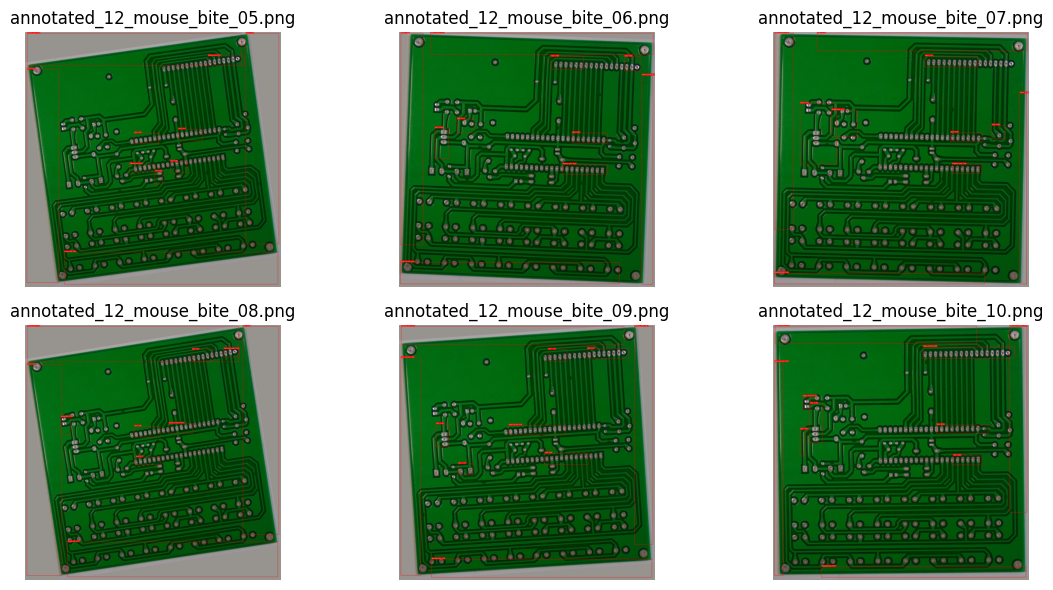

In [16]:
# Cell: show 6 recent annotated images inline
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

out = Path("inference_results_module06_batch")
imgs = sorted(out.glob("annotated_*.png"))
print("Annotated images found:", len(imgs))
sample = imgs[-6:] if len(imgs) >= 6 else imgs

plt.figure(figsize=(12,6))
for i, p in enumerate(sample, 1):
    img = Image.open(p)
    plt.subplot(2, 3, i)
    plt.imshow(img); plt.title(p.name); plt.axis("off")
plt.tight_layout()
